/tmp/ipykernel_3182396/1061262018.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


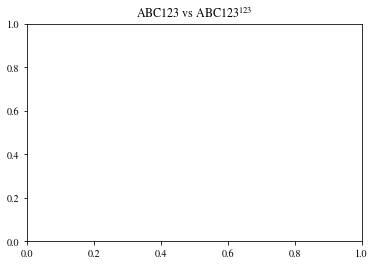

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from botorch.test_functions import Levy
from botorch.utils.transforms import unnormalize
from botorch.models.transforms.input import InputPerturbation
from botorch.utils.sampling import draw_sobol_samples, draw_sobol_normal_samples
from botorch.acquisition.multi_objective.multi_output_risk_measures import MVaR
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
# matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]

In [2]:
pal = sns.color_palette("viridis", as_cmap=False, n_colors=10)
pal

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

In [3]:
pal2 = sns.color_palette("Set1", as_cmap=False, n_colors=10)
pal2

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [26]:
tkwargs = {"dtype": torch.double}
torch.manual_seed(1234)

In [27]:
def func(x):
    p1 = 2.4 - 10 * x - 0.1*x.pow(2)
    p2 = 2 * x - 0.1*x.pow(2)
    break_point = 0.2
    smoother = (x - 0.5).pow(2) + torch.sin(30 * x) * 0.1
    x_mask = torch.sigmoid((break_point - x)/0.005)
    return (p1 * x_mask + p2 * (1-x_mask) + smoother).view(-1) *30 -30


levy = Levy().to(**tkwargs)

def modified_levy(X):
    X = torch.cat(
        [X, torch.zeros_like(X)], dim=-1,
    )
    # Cut out the first part of the function.
    X = X * 0.95 + 0.03
    X = unnormalize(X, levy.bounds)
    Y = levy(X)
    Y -= X[:, 0].pow(2) * 0.75
    return Y.view(-1)

def eval_problem(X):
    f1 = -func(X)
    f2 = modified_levy(X)
    return torch.stack([f1,f2], dim=-1)

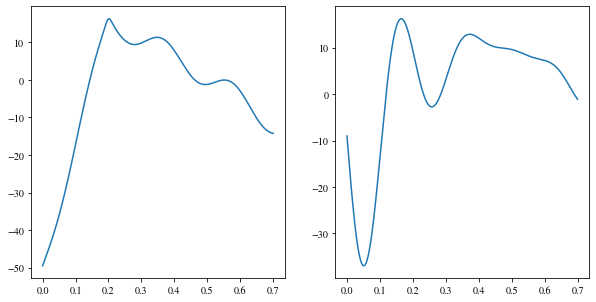

In [28]:
x = torch.linspace(0, 0.7,1001,**tkwargs).view(-1,1)
y = eval_problem(x)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x.cpu(),y[:,0].cpu())
ax[1].plot(x.cpu(),y[:,1].cpu())

In [29]:
from botorch.utils.multi_objective.pareto import is_non_dominated

mask = is_non_dominated(y)
pf = y[mask]
ps = x[mask]


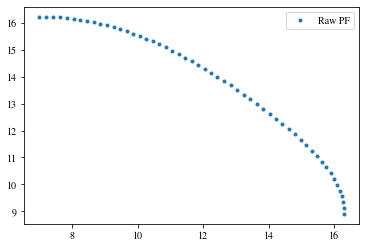

In [30]:
plt.plot(pf[:,0].cpu(), pf[:,1].cpu(), '.', label="Raw PF")
plt.legend()

In [31]:
bounds = torch.zeros(2, 1)
standard_bounds = torch.zeros(2, 1)
standard_bounds[1]
ALPHA = 0.9
standard_bounds[0] = 0.00
standard_bounds[1] = 0.7
std_dev = 0.1
n_w = 64
perturbation_set = draw_sobol_normal_samples(d=1, n=n_w, **tkwargs) * std_dev
intf_eval = InputPerturbation(
    perturbation_set=perturbation_set, bounds=standard_bounds
).eval()
objective_eval = MVaR( # note this does not evaluate union-MVAR, it evaluates MVaR independently for each point
    n_w=n_w,
    alpha=ALPHA,
    expectation=False,
    pad_to_n_w=False,
    filter_dominated=True,
)
robust_eval_x = intf_eval(x)
raw_outcomes = eval_problem(robust_eval_x)
print(raw_outcomes.shape)
raw_outcomes = raw_outcomes.view(x.shape[0],-1, 2)
robust_obj = objective_eval(raw_outcomes).cpu()
robust_mask = is_non_dominated(robust_obj.view(-1,2))
robust_pf = robust_obj.view(-1,2)[robust_mask]
exp_obj = raw_outcomes.mean(dim=1)
exp_mask = is_non_dominated(exp_obj.view(-1, 2))
exp_pf = exp_obj.view(-1, 2)[exp_mask]


torch.Size([64064, 2])


RuntimeError: std::bad_alloc

In [ ]:
X = x
expanded_X = X.unsqueeze(dim=-2).expand(
            *X.shape[:-1], perturbation_set.shape[0], -1
        )
expanded_X.shape

In [ ]:
expanded_perturbations = perturbation_set.expand(
            *expanded_X.shape[:-1], -1
        )
perturbed_inputs = expanded_X + expanded_perturbations
perturbed_inputs.shape

In [ ]:
perturbed_inputs = perturbed_inputs.reshape(*X.shape[:-2], -1, X.shape[-1])

In [32]:
perturbed_inputs.shape

torch.Size([64064, 1])

In [33]:
x_level_mask = robust_mask.view(robust_obj.shape[:-1]).any(dim=-1)
robust_ps = x[x_level_mask]
exp_x_level_mask = exp_mask
exp_ps = x[exp_x_level_mask]

In [34]:
from botorch.utils.multi_objective.hypervolume import infer_reference_point

ref_point = infer_reference_point(robust_pf)
ref_point

tensor([-7.7798, -3.6519], dtype=torch.float64)

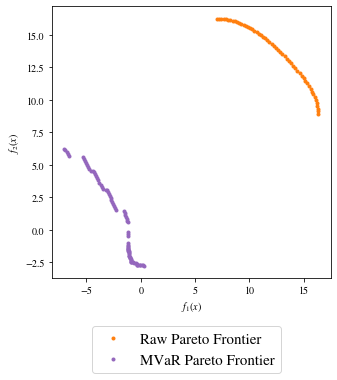

In [35]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.plot(pf[:, 0].cpu(), pf[:, 1].cpu(),  ".", color="C1",label="Raw Pareto Frontier")
plt.plot(robust_pf[:, 0].cpu(), robust_pf[:, 1].cpu(), ".", color="tab:purple",  label="MVaR Pareto Frontier")
plt.xlabel(r"$f_1(x)$")
plt.ylabel(r"$f_2(x)$")
plt.legend(fontsize=15, bbox_to_anchor=(0.85,-0.15,0,0))


In [36]:
from botorch.utils.multi_objective.box_decompositions import DominatedPartitioning


DominatedPartitioning(ref_point=ref_point, Y=robust_pf).compute_hypervolume()


tensor(52.3966, dtype=torch.float64)

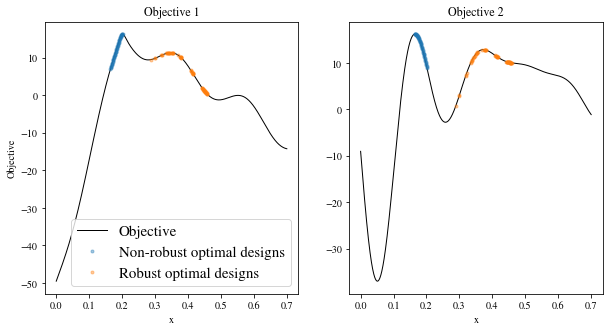

In [37]:
y = eval_problem(x)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax[i].plot(x.cpu(), y[:, i].cpu(), lw=1, label="Objective", color='k')
    ax[i].plot(ps.cpu(), eval_problem(ps).cpu()[:, i], ".", label="Non-robust optimal designs", alpha=0.4)
    ax[i].plot(
        robust_ps.cpu(), eval_problem(robust_ps).cpu()[:, i], ".", label="Robust optimal designs", alpha=0.4
    )
ax[0].set_xlabel("x")
ax[1].set_xlabel("x")
ax[0].set_ylabel("Objective")
ax[0].set_title("Objective 1")
ax[1].set_title("Objective 2")
ax[0].legend(fontsize=15)


In [38]:
fontdict = {'fontsize': 16}

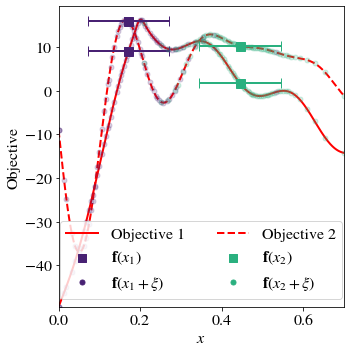

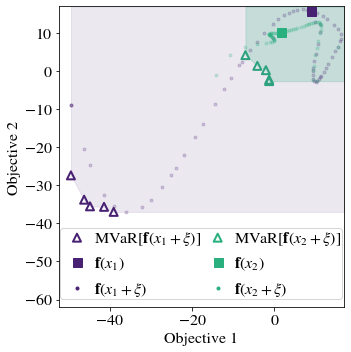

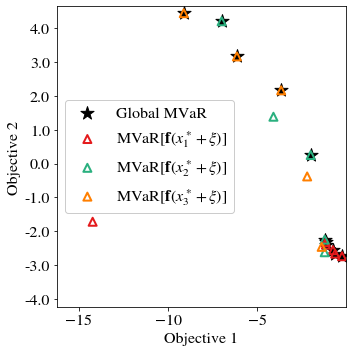

In [39]:
y = eval_problem(x)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x.cpu(), y[:, 0].cpu(), lw=2, label="Objective 1", color='red')
ax.plot(x.cpu(), y[:, 1].cpu(), lw=2, label="Objective 2", ls='--', color='red')

for i in range(2):
#     ax.plot(ps.cpu(), eval_problem(ps).cpu()[:, i], ".", label="Non-robust Pareto set" if i ==0 else None, color=pal[0], alpha=0.2)
#     ax.plot(
#         robust_ps.cpu(), eval_problem(robust_ps).cpu()[:, i], ".", label="Robust Pareto set" if i ==0 else None, color=pal[-4],alpha=0.2
    
#     )
    idx = (ps.shape[0])//5
    robust_idx = (robust_ps.shape[0]*2)//3
    # plot robust and non robust design (without input noise)
    ax.scatter(
        ps[idx].cpu(), 
        eval_problem(ps).cpu()[idx, i],  
        marker="s", 
        s=8*9, 
        color=pal[0],
        label=r"$\mathbf{f}(x_1)$" if i == 0 else None,
    )
    ax.scatter(
        robust_ps[robust_idx].cpu(), 
        eval_problem(robust_ps).cpu()[robust_idx, i], 
        marker="s", 
        s=8*9, 
        color=pal[-4],
        label=r"$\mathbf{f}(x_2)$" if i == 0 else None,
    )
    ax.errorbar(
        x=ps[idx].cpu(), 
        y=eval_problem(ps).cpu()[idx, i], 
        xerr=std_dev, 
        marker="s", 
        markersize=9, 
        color=pal[0],
        capsize=5,
        lw=2,
#         label=r"$\mathbf{f}(x_1)$" if i == 0 else None,
    )
    ax.errorbar(
        x=robust_ps[robust_idx].cpu(), 
        y=eval_problem(robust_ps).cpu()[robust_idx, i], 
        xerr=std_dev, 
        marker="s", 
        markersize=9, 
        color=pal[-4],
        capsize=5,
        lw=2,
#         label=r"$\mathbf{f}(x_2)$" if i == 0 else None,
    )
    # plot robust and non robust design (with input noise)
    perturbed_nominal_design = intf_eval(ps[idx])
    raw_outcomes_nominal_design = eval_problem(perturbed_nominal_design)
    ax.plot(perturbed_nominal_design.cpu(), raw_outcomes_nominal_design.cpu()[:, i], ".", label=r"$\mathbf{f}(x_1 + \xi)$" if i ==0 else None, color=pal[0],markersize=10, alpha=0.2)
    perturbed_robust_design = intf_eval(robust_ps[robust_idx])
    raw_outcomes_robust_design = eval_problem(perturbed_robust_design)
    ax.plot(perturbed_robust_design.cpu(), raw_outcomes_robust_design.cpu()[:, i], ".", label=r"$\mathbf{f}(x_2 + \xi)$" if i ==0 else None, color=pal[-4],markersize=10, alpha=0.2)

    


ax.set_xlabel("$x$", **fontdict)
ax.set_ylabel("Objective", **fontdict)
# ax.set_title("Objectives", **fontdict)
y_min, y_max = ax.yaxis.get_data_interval()
# ax.axhline(y_min+0.5, 0, 0+std_dev, color="k", lw=3, label="Input noise standard deviation")
ax.set_ylim(y_min-0.05, y_max+3)
ax.set_xlim(0, 0.7)
handles, labels = ax.get_legend_handles_labels()
handles2 = []
labels2 = []
for i in [0,2,4,1,3,5]:
    handles2.append(handles[i])
    labels2.append(labels[i])
leg = ax.legend(handles2, labels2, ncol=2, loc="lower center", **fontdict)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.tick_params(labelsize=fontdict['fontsize'])
fig.tight_layout()
plt.savefig("plots/1d_toy_functions_single_designs.pdf", dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel("Objective 1", **fontdict)
ax.set_ylabel("Objective 2", **fontdict)
non_robust_ys = objective_eval(eval_problem(intf_eval(ps[idx].view(-1,1)).view(-1,1)).cuda()).view(-1,2).cpu()

robust_ys = objective_eval(eval_problem(intf_eval(robust_ps[robust_idx].view(-1,1)).view(-1,1)).cuda()).view(-1,2).cpu()
nominal_y = eval_problem(ps[idx].view(1,1))
nominal_robust_y = eval_problem(robust_ps[robust_idx].view(1,1))

ax.plot(nominal_y[:,0], nominal_y[:,1],  "s", markersize=9, color=pal[0], label=r"$\mathbf{f}(x_1)$")
ax.plot(nominal_robust_y[:,0], nominal_robust_y[:,1],  "s", markersize=9, color=pal[-4], label=r"$\mathbf{f}(x_2)$")
import matplotlib.markers as markers
marker = markers.MarkerStyle(marker='^', fillstyle='none')
# ax.plot(non_robust_ys[:,0], non_robust_ys[:,1],  "^", color=pal[0], label=r"MVaR$[\mathbf{f}(x_1 + \xi)]$")
plt.scatter(non_robust_ys[:,0], non_robust_ys[:,1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x_1 + \xi)]$", color=pal[0], alpha=1, linewidth=2)

# ax.plot(robust_ys[:,0], robust_ys[:,1],  "^", color=pal[-4], label=r"MVaR$[\mathbf{f}(x_2 + \xi)]$")
plt.scatter(robust_ys[:,0], robust_ys[:,1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x_2 + \xi)]$", color=pal[-4], alpha=1, linewidth=2)

ax.plot(raw_outcomes_nominal_design.cpu()[:, 0].cpu(), raw_outcomes_nominal_design.cpu()[:, 1].cpu(), ".", label=r"$\mathbf{f}(x_1 + \xi)$", color=pal[0], alpha=0.2)
ax.plot(raw_outcomes_robust_design.cpu()[:, 0].cpu(), raw_outcomes_robust_design.cpu()[:, 1].cpu(), ".", label=r"$\mathbf{f}(x_2 + \xi)$", color=pal[-4], alpha=0.2)
# ax.plot(raw_outcomes_nominal_design.cpu()[:, 0].cpu().mean(), raw_outcomes_nominal_design.cpu()[:, 1].cpu().mean(), "^", label=r"$\mathbb{E}[\mathbf{f}(x_1 + \xi)]$", color=pal[0], alpha=1)
# ax.plot(raw_outcomes_robust_design.cpu()[:, 0].cpu().mean(), raw_outcomes_robust_design.cpu()[:, 1].cpu().mean(), "^", label=r"$\mathbb{E}[\mathbf{f}(x_2 + \xi)]$", color=pal[-4], alpha=1)

# ax.set_title(r"High probability domain of $\mathbf{f}(x)$ under input noise", **fontdict)

bd = DominatedPartitioning(Y=-non_robust_ys, ref_point=-torch.tensor([17.0, 17.0], **tkwargs))
cells = -bd.get_hypercell_bounds().flip(dims=[0])
# for j in range(cells.shape[-2]):
xs = cells[:1,:,:1].view(-1)
y1 = cells[0,:, 1].view(-1)
y2 = cells[1,:, 1].view(-1)
xs = torch.cat([cells[1,0, :1].view(-1), xs, ], dim=0)
y1 = torch.cat([cells[0,0, 1].view(-1), y1, ], dim=0)
y2 = torch.cat([cells[1,0, 1].view(-1), y2, ], dim=0)
ax.fill_between(x=xs, y1=y1, y2=y2, color=pal[0], alpha=0.1)
bd = DominatedPartitioning(Y=-robust_ys, ref_point=-torch.tensor([17.0, 17.0], **tkwargs))
cells = -bd.get_hypercell_bounds().flip(dims=[0])
# for j in range(cells.shape[-2]):
xs = cells[:1,:,:1].view(-1)
y1 = cells[0,:, 1].view(-1)
y2 = cells[1,:, 1].view(-1)
xs = torch.cat([cells[1,0, :1].view(-1), xs, ], dim=0)
y1 = torch.cat([cells[0,0, 1].view(-1), y1, ], dim=0)
y2 = torch.cat([cells[1,0, 1].view(-1), y2, ], dim=0)
ax.fill_between(x=xs, y1=y1, y2=y2, color=pal[-4], alpha=0.2)
y_min, y_max = ax.yaxis.get_data_interval()
x_min, x_max = ax.xaxis.get_data_interval()
ax.set_xlim(x_min-3, 17)
ax.set_ylim(y_min-25,17)
handles, labels = ax.get_legend_handles_labels()
handles2 = []
labels2 = []
for i in [2,0,4,3,1,5]:
    handles2.append(handles[i])
    labels2.append(labels[i])
leg = ax.legend(handles2, labels2, ncol=2, loc="lower center", columnspacing=0.05, borderpad=0.05, handletextpad=0.05, **fontdict)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.tick_params(labelsize=fontdict['fontsize'])


fig.tight_layout()
plt.savefig("plots/1d_toy_mvar_single_designs.pdf", dpi=300, transparent=True)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel("Objective 1", **fontdict)
ax.set_ylabel("Objective 2", **fontdict)

idcs = [10, robust_idx, -1]
mvar_all_list = []
for i in idcs:
    mvar_i = objective_eval(eval_problem(intf_eval(robust_ps[i].view(-1,1)).view(-1,1))).view(-1,2)
    mvar_all_list.append(mvar_i)
    
mvar_all = torch.cat(mvar_all_list, dim=0)
mask = is_non_dominated(mvar_all)
global_mvar = mvar_all[mask]

plt.scatter(global_mvar[:,0], global_mvar[:,1], marker='*', color='k', s=8*8*3, label=r"Global MVaR")
mvar_i = mvar_all_list[0]
plt.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_1 + \xi)]$", color=pal2[0], alpha=1, linewidth=2)
mvar_i = mvar_all_list[1]
plt.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_2 + \xi)]$", color=pal[-4], alpha=1, linewidth=2)
mvar_i = mvar_all_list[2]
plt.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_3 + \xi)]$", color=pal2[4], alpha=1, linewidth=2)
y_min, y_max = ax.yaxis.get_data_interval()
x_min, x_max = ax.xaxis.get_data_interval()
ax.set_xlim(x_min-2, x_max+0.2)
ax.set_ylim(y_min-1.5,y_max+0.2)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.tick_params(labelsize=fontdict['fontsize'])
leg = ax.legend(**fontdict)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((1, 1, 1, 1))
fig.tight_layout()
plt.savefig("plots/1d_toy_mvar_single_designs_global.pdf", dpi=300, transparent=True)
plt.show()


In [40]:
from typing import Tuple

import numpy as np
import torch
from botorch.utils.multi_objective.pareto import is_non_dominated
from torch import Tensor
def pareto_sort(pareto_Y: Tensor) -> Tuple[Tensor, Tensor]:
    r"""Sort 2 objectives in non-decreasing and non-increasing order respectively.

    Args:
        pareto_Y: a `(batch_shape) x n_pareto x 2`-dim tensor of pareto outcomes

    Returns:
        2-element tuple containing

        - A `(batch_shape) x n_pareto x 2`-dim tensor of sorted values
        - A `(batch_shape) x n_pareto`-dim tensor of indices
    """
    if pareto_Y.shape[-1] != 2:
        raise NotImplementedError(
            f"There must be exactly 2 objectives, got {pareto_Y.shape[-1]}."
        )
    # sort by second outcome
    # this tensor is batch_shape x n
    inner_sorting = torch.argsort(pareto_Y[..., 1], descending=True)
    # expand to batch_shape x n x 2
    inner_sorting = inner_sorting.unsqueeze(-1).expand(
        *inner_sorting.shape, pareto_Y.shape[-1]
    )
    pareto_Y_inner_sorted = pareto_Y.gather(-2, inner_sorting)
    # this tensor is batch_shape x n
    # TODO: replace numpy stable sorting https://github.com/pytorch/pytorch/issues/28871
    outer_sorting = torch.from_numpy(
        np.argsort(pareto_Y_inner_sorted[..., 0].cpu().numpy(), kind="stable", axis=-1)
    ).to(device=pareto_Y.device)
    # expand to batch_shape x n x 2
    outer_sorting = outer_sorting.unsqueeze(-1).expand(
        *outer_sorting.shape, pareto_Y.shape[-1]
    )
    values = pareto_Y_inner_sorted.gather(-2, outer_sorting)
    indices = inner_sorting[..., 0].gather(dim=-1, index=outer_sorting[..., 0])
    return values, indices

def get_rectangular_front(pareto_Y, ref_point):
    sorted_pareto_Y = pareto_sort(pareto_Y)[0]
    lower_lefts = torch.cat([
        torch.cat([ref_point[0:1], sorted_pareto_Y[0,1:2]], dim=0).unsqueeze(0),
        torch.cat([sorted_pareto_Y[:-1,0:1], sorted_pareto_Y[1:,1:2]], dim=-1),
        torch.cat([sorted_pareto_Y[-1, 0:1], ref_point[1:2]], dim=0).unsqueeze(0),
    ], dim=0)
    rect_front = torch.cat([
            lower_lefts[i//2:i//2+1]
            if i % 2 == 0
            else
            sorted_pareto_Y[i//2:i//2+1] for i in range(lower_lefts.shape[0]+sorted_pareto_Y.shape[0] )
    ], dim=0)
    return rect_front

TransformedBbox(
    Bbox(x0=0.15, y0=0.56, x1=0.35, y1=0.56),
    BboxTransformTo(
        TransformedBbox(
            Bbox(x0=0.125, y0=0.125, x1=0.3529411764705882, y1=0.88),
            BboxTransformTo(
                TransformedBbox(
                    Bbox(x0=0.0, y0=0.0, x1=16.0, y1=5.0),
                    Affine2D().scale(72.0))))))


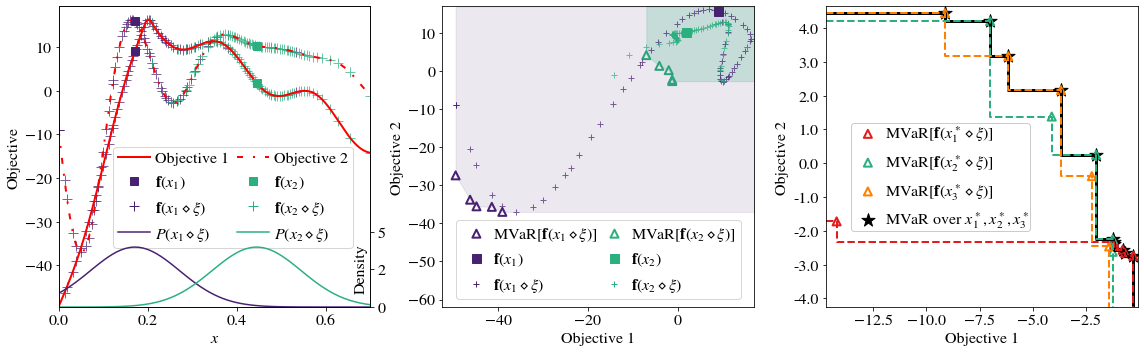

In [46]:
y = eval_problem(x)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), gridspec_kw={"width_ratios": [5, 5, 5]})
ax = axes[0]

for i in range(2):
#     ax.plot(ps.cpu(), eval_problem(ps).cpu()[:, i], ".", label="Non-robust Pareto set" if i ==0 else None, color=pal[0], alpha=0.2)
#     ax.plot(
#         robust_ps.cpu(), eval_problem(robust_ps).cpu()[:, i], ".", label="Robust Pareto set" if i ==0 else None, color=pal[-4],alpha=0.2
    
#     )
    idx = (ps.shape[0])//5
    robust_idx = (robust_ps.shape[0]*2)//3
    # plot robust and non robust design (without input noise)
    perturbed_nominal_design = intf_eval(ps[idx])
    raw_outcomes_nominal_design = eval_problem(perturbed_nominal_design)
    ax.plot(perturbed_nominal_design.cpu(), raw_outcomes_nominal_design.cpu()[:, i], marker="+", linestyle='None', label=r"$\mathbf{f}(x_1 \diamond \xi)$" if i ==0 else None, color=pal[0],markersize=10, alpha=0.7)
    perturbed_robust_design = intf_eval(robust_ps[robust_idx])
    raw_outcomes_robust_design = eval_problem(perturbed_robust_design)
    ax.plot(perturbed_robust_design.cpu(), raw_outcomes_robust_design.cpu()[:, i], marker="+", linestyle='None', label=r"$\mathbf{f}(x_2 \diamond \xi)$" if i ==0 else None, color=pal[-4],markersize=10, alpha=0.7)


ax.plot(x.cpu(), y[:, 0].cpu(), lw=2, label="Objective 1", color='red')
ax.plot(x.cpu(), y[:, 1].cpu(), lw=2, label="Objective 2", ls=(0,(3,5,1,5)), color='red')
for i in range(2):
#     ax.plot(ps.cpu(), eval_problem(ps).cpu()[:, i], ".", label="Non-robust Pareto set" if i ==0 else None, color=pal[0], alpha=0.2)
#     ax.plot(
#         robust_ps.cpu(), eval_problem(robust_ps).cpu()[:, i], ".", label="Robust Pareto set" if i ==0 else None, color=pal[-4],alpha=0.2
    
#     )
    idx = (ps.shape[0])//5
    robust_idx = (robust_ps.shape[0]*2)//3
    # plot robust and non robust design (without input noise)
    ax.plot(
        ps[idx].cpu(), 
        eval_problem(ps).cpu()[idx, i],  
        marker="s", 
#         s=8*9, 
        ms=8,
        linestyle='None',
        color=pal[0],
        label=r"$\mathbf{f}(x_1)$" if i == 0 else None,
    )
    ax.plot(
        robust_ps[robust_idx].cpu(), 
        eval_problem(robust_ps).cpu()[robust_idx, i], 
        marker="s", 
#         s=8*9, 
        ms=8,
        linestyle='None',
        color=pal[-4],
        label=r"$\mathbf{f}(x_2)$" if i == 0 else None,
    )
from scipy.stats import norm
import statistics
  
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0,1, 0.01)
ax2 = ax.twinx()
ax2.plot(x_axis, norm.pdf(x_axis, ps[idx], 0.1), color=pal[0], label=r"$P(x_1 \diamond \xi)$")
ax2.plot(x_axis, norm.pdf(x_axis, robust_ps[robust_idx], 0.1), color=pal[-4], label=r"$P(x_2 \diamond \xi)$")
ax2.set_ylim(0,20)
labs = ax2.get_yticks()
ax2.set_yticks(labs[:3])
# ax2.set_yticks([])
ax2.set_ylabel('Density', **fontdict)  # we already handled the x-label with ax1
# print(ax2.yaxis.get_label_position())
ax2.yaxis.set_label_coords(0.95, 0.13)
ax2.tick_params(labelsize=fontdict['fontsize'])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

ax.set_xlabel("$x$", **fontdict)
ax.set_ylabel("Objective", **fontdict)
# ax.set_title("Objectives", **fontdict)
y_min, y_max = ax.yaxis.get_data_interval()
# ax.axhline(y_min+0.5, 0, 0+std_dev, color="k", lw=3, label="Input noise standard deviation")
ax.set_ylim(y_min-0.05, y_max+3)
ax.set_xlim(0, 0.7)
handles, labels = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
handles_c, labels_c = [], []
handles_c.extend(handles)
handles_c.extend(h2)
labels_c.extend(labels)
labels_c.extend(l2)
handles2 = []
labels2 = []
for i in [2,4,0,6,3,5,1,7]:
    handles2.append(handles_c[i])
    labels2.append(labels_c[i])
leg = ax.legend(
    handles2, 
    labels2, 
    ncol=2, 
#     loc="center right",
    bbox_to_anchor=(0.15, 0.56, 0.2, 0.),
    columnspacing=0.5, 
    borderpad=0.3, 
    handletextpad=0.3,
    handlelength=2,
    **fontdict,
)
print(leg.get_bbox_to_anchor())
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.tick_params(labelsize=fontdict['fontsize'])
# fig.tight_layout()
# plt.savefig("plots/1d_toy_functions_single_designs.pdf", dpi=300, transparent=True)
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = axes[1]
ax.set_xlabel("Objective 1", **fontdict)
ax.set_ylabel("Objective 2", **fontdict)
non_robust_ys = objective_eval(eval_problem(intf_eval(ps[idx].view(-1,1)).view(-1,1)).cuda()).view(-1,2).cpu()

robust_ys = objective_eval(eval_problem(intf_eval(robust_ps[robust_idx].view(-1,1)).view(-1,1)).cuda()).view(-1,2).cpu()
nominal_y = eval_problem(ps[idx].view(1,1))
nominal_robust_y = eval_problem(robust_ps[robust_idx].view(1,1))

ax.plot(nominal_y[:,0], nominal_y[:,1],  "s", markersize=9, color=pal[0], label=r"$\mathbf{f}(x_1)$")
ax.plot(nominal_robust_y[:,0], nominal_robust_y[:,1],  "s", markersize=9, color=pal[-4], label=r"$\mathbf{f}(x_2)$")
import matplotlib.markers as markers
marker = markers.MarkerStyle(marker='^', fillstyle='none')
# ax.plot(non_robust_ys[:,0], non_robust_ys[:,1],  "^", color=pal[0], label=r"MVaR$[\mathbf{f}(x_1 + \xi)]$")
ax.scatter(non_robust_ys[:,0], non_robust_ys[:,1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x_1 \diamond \xi)]$", color=pal[0], alpha=1, linewidth=2)

# ax.plot(robust_ys[:,0], robust_ys[:,1],  "^", color=pal[-4], label=r"MVaR$[\mathbf{f}(x_2 + \xi)]$")
ax.scatter(robust_ys[:,0], robust_ys[:,1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x_2 \diamond \xi)]$", color=pal[-4], alpha=1, linewidth=2)

ax.plot(raw_outcomes_nominal_design.cpu()[:, 0].cpu(), raw_outcomes_nominal_design.cpu()[:, 1].cpu(), "+", label=r"$\mathbf{f}(x_1 \diamond \xi)$", color=pal[0], alpha=0.7)
ax.plot(raw_outcomes_robust_design.cpu()[:, 0].cpu(), raw_outcomes_robust_design.cpu()[:, 1].cpu(), "+", label=r"$\mathbf{f}(x_2 \diamond \xi)$", color=pal[-4], alpha=0.7)
# ax.plot(raw_outcomes_nominal_design.cpu()[:, 0].cpu().mean(), raw_outcomes_nominal_design.cpu()[:, 1].cpu().mean(), "^", label=r"$\mathbb{E}[\mathbf{f}(x_1 + \xi)]$", color=pal[0], alpha=1)
# ax.plot(raw_outcomes_robust_design.cpu()[:, 0].cpu().mean(), raw_outcomes_robust_design.cpu()[:, 1].cpu().mean(), "^", label=r"$\mathbb{E}[\mathbf{f}(x_2 + \xi)]$", color=pal[-4], alpha=1)

# ax.set_title(r"High probability domain of $\mathbf{f}(x)$ under input noise", **fontdict)

bd = DominatedPartitioning(Y=-non_robust_ys, ref_point=-torch.tensor([17.0, 17.0], **tkwargs))
cells = -bd.get_hypercell_bounds().flip(dims=[0])
# for j in range(cells.shape[-2]):
xs = cells[:1,:,:1].view(-1)
y1 = cells[0,:, 1].view(-1)
y2 = cells[1,:, 1].view(-1)
xs = torch.cat([cells[1,0, :1].view(-1), xs, ], dim=0)
y1 = torch.cat([cells[0,0, 1].view(-1), y1, ], dim=0)
y2 = torch.cat([cells[1,0, 1].view(-1), y2, ], dim=0)
ax.fill_between(x=xs, y1=y1, y2=y2, color=pal[0], alpha=0.1)
bd = DominatedPartitioning(Y=-robust_ys, ref_point=-torch.tensor([17.0, 17.0], **tkwargs))
cells = -bd.get_hypercell_bounds().flip(dims=[0])
# for j in range(cells.shape[-2]):
xs = cells[:1,:,:1].view(-1)
y1 = cells[0,:, 1].view(-1)
y2 = cells[1,:, 1].view(-1)
xs = torch.cat([cells[1,0, :1].view(-1), xs, ], dim=0)
y1 = torch.cat([cells[0,0, 1].view(-1), y1, ], dim=0)
y2 = torch.cat([cells[1,0, 1].view(-1), y2, ], dim=0)
ax.fill_between(x=xs, y1=y1, y2=y2, color=pal[-4], alpha=0.2)
y_min, y_max = ax.yaxis.get_data_interval()
x_min, x_max = ax.xaxis.get_data_interval()
ax.set_xlim(x_min-3, 17)
ax.set_ylim(y_min-25,17)
handles, labels = ax.get_legend_handles_labels()
handles2 = []
labels2 = []
for i in [2,0,4,3,1,5]:
    handles2.append(handles[i])
    labels2.append(labels[i])
leg = ax.legend(handles2, labels2, ncol=2, loc="lower center", columnspacing=0.05, borderpad=0.3, handletextpad=0.05, **fontdict)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.tick_params(labelsize=fontdict['fontsize'])


# fig.tight_layout()
# plt.savefig("plots/1d_toy_mvar_single_designs.pdf", dpi=300, transparent=True)
# plt.show()
ax = axes[2]
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlabel("Objective 1", **fontdict)
ax.set_ylabel("Objective 2", **fontdict)

idcs = [10, robust_idx, -1]
mvar_all_list = []
for i in idcs:
    mvar_i = objective_eval(eval_problem(intf_eval(robust_ps[i].view(-1,1)).view(-1,1)).cuda()).view(-1,2).cpu()
    mvar_all_list.append(mvar_i)
    
mvar_all = torch.cat(mvar_all_list, dim=0)
mask = is_non_dominated(mvar_all)
global_mvar = mvar_all[mask]
# limit = torch.tensor([x_min, y_min], dtype=global_mvar.dtype)
limit = torch.tensor([-1.2743814622879889e+01-2, -2.754541883710658-1.5], dtype=global_mvar.dtype)
ax.scatter(global_mvar[:,0], global_mvar[:,1], marker='*', color='k', s=8*8*3, 
#            label=r"Global MVaR",
           label=r"MVaR over $x^*_1, x^*_2, x^*_3$",
           
          )
front = get_rectangular_front(global_mvar, limit)
ax.plot(front[:,0], front[:,1], color='k', lw=3)
mvar_i = mvar_all_list[0]
front = get_rectangular_front(mvar_i, limit)
ax.plot(front[:,0], front[:,1], '--', lw=2, color=pal2[0])
ax.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_1 \diamond \xi)]$", color=pal2[0], alpha=1, linewidth=2)

mvar_i = mvar_all_list[1]
front = get_rectangular_front(mvar_i, limit)
ax.plot(front[:,0], front[:,1], '--', lw=2, color=pal[-4])
ax.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_2 \diamond \xi)]$", color=pal[-4], alpha=1, linewidth=2)


mvar_i = mvar_all_list[2]
front = get_rectangular_front(mvar_i, limit)
ax.plot(front[:,0], front[:,1], '--', lw=2, color=pal2[4], )
ax.scatter(mvar_i[:,0], mvar_i[:, 1], marker=marker, s=8*8, label=r"MVaR$[\mathbf{f}(x^*_3 \diamond \xi)]$", color=pal2[4], alpha=1, linewidth=2)


y_min, y_max = ax.yaxis.get_data_interval()
x_min, x_max = ax.xaxis.get_data_interval()
x_min = limit[0].item()+2
y_min = limit[1].item()+1.5
# print((x_min, y_min))
ax.set_xlim(x_min-2, x_max+0.2)
ax.set_ylim(y_min-1.5,y_max+0.2)
# ax.set_xlim(x_min-3, 17)
# ax.set_ylim(y_min-25,17)
from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.tick_params(labelsize=fontdict['fontsize'])
handles, labels = ax.get_legend_handles_labels()
handles2 = []
labels2 = []
for i in [1,2,3,0]:
    handles2.append(handles[i])
    labels2.append(labels[i])
leg = ax.legend(handles2, labels2, bbox_to_anchor=(0.48, 0.64, 0.2, 0.),borderpad=0.05, handletextpad=0.05,**fontdict)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((1, 1, 1, 1))
fig.tight_layout()
plt.subplots_adjust(wspace=0.23)
plt.savefig("plots/1d_toy_mvar_single_designs_combined.pdf", dpi=300, transparent=True)
plt.show()
